# Tutorial 7 : Neural Process Graphs

Last Update : 28 July 2019

**Aim**: 


In [1]:
N_THREADS = 12
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Environment

In [2]:
cd ..

/conv


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset 

In [4]:
from torch_geometric.datasets import TUDataset
from sklearn.preprocessing import StandardScaler

In [5]:
def print_dataset(dataset):
    num_nodes = num_edges = 0
    for data in dataset:
        num_nodes += data.num_nodes
        num_edges += data.num_edges

    print('Name', dataset)
    print('Graphs', len(dataset))
    print('Nodes', num_nodes / len(dataset))
    print('Edges', (num_edges // 2) / len(dataset))
    print('Features', dataset.num_features)
    print('Classes', dataset.num_classes)
    print("Mode Baseline", mode_baeline_acc(dataset))
    print(dataset[0])
    print()

In [6]:
datasets=dict(enzymes = TUDataset(root='data/ENZYMES', name='ENZYMES', use_node_attr=True, ),
             proteins = TUDataset(root='data/PROTEINS_full', name='PROTEINS_full', use_node_attr=True),
             synthie = TUDataset(root='data/Synthie', name='Synthie', use_node_attr=True))

In [7]:
def mode_baeline_acc(g):
    mode = d.data.y.mode()[0].item()
    return (d.data.y == mode).float().mean()

In [8]:
for d in datasets.values():
    print_dataset(d)
    print()

Name ENZYMES(600)
Graphs 600
Nodes 32.63333333333333
Edges 62.13666666666666
Features 21
Classes 6
Mode Baseline tensor(0.1667)
Data(edge_index=[2, 168], x=[37, 21], y=[1])


Name PROTEINS_full(1113)
Graphs 1113
Nodes 39.05750224618149
Edges 72.8158131176999
Features 32
Classes 2
Mode Baseline tensor(0.5957)
Data(edge_index=[2, 162], x=[42, 32], y=[1])


Name Synthie(400)
Graphs 400
Nodes 95.0
Edges 172.9275
Features 15
Classes 4
Mode Baseline tensor(0.2750)
Data(edge_index=[2, 294], x=[90, 15], y=[1])




In [9]:
from random import shuffle
from torch_geometric.datasets import TUDataset, Planetoid, PPI, QM7b, ModelNet
from sklearn.preprocessing import StandardScaler

from torch_geometric.datasets import TUDataset, Planetoid, PPI, QM7b, ModelNet
from sklearn.preprocessing import StandardScaler
from utils.data.helpers import make_ssl_dataset_
from copy import deepcopy

datasets=dict(enzymes = TUDataset(root='data/ENZYMES', name='ENZYMES', use_node_attr=True, ),
             proteins = TUDataset(root='data/PROTEINS_full', name='PROTEINS_full', use_node_attr=True),
             synthie = TUDataset(root='data/Synthie', name='Synthie', use_node_attr=True))

data_specific_kwargs = {k:dict(y_dim=d.num_node_features,
                               t_dim=d.num_classes
                              ) 
                        for k,d in datasets.items()}

def train_test_split(d, transform=lambda x : StandardScaler().fit_transform(x)):
    if transform is not None:
        d.data.x = torch.from_numpy(transform(d.data.x.numpy()))
    d = d.shuffle()
    return d[:-len(d) // 10], d[-len(d) // 10:]

from skssl.utils.helpers import cont_tuple_to_tuple_cont

def ssl_graph(train_test, label_perc=0.1, is_add_test=True, is_augment=True):
    train, test = train_test
    make_ssl_dataset_(train, label_perc, is_graph=True)
    list_train, list_test = list(train), list(test)
    
    if is_add_test:
        test = deepcopy(test)
        test.data.y = torch.ones_like(test.data.y) * -1
        list_train += list(test)
        
    if is_augment:
        indcs_labels = (train.data.y != -1)
        factor = int((1 - label_perc)/label_perc)-1
        labeled_data = [d for d,i in zip(list_train, indcs_labels) if i]
        list_train += labeled_data * factor
        
    return list_train, list_test

In [10]:
X_DIM = 2  # 2D spatial input 
#Y_DIM = data.shape[0]
N_TARGETS = None#data.n_classes

label_percentages = [0.01, 0.05, 0.1, 0.3, 0.5, 1]

In [11]:
from skssl.transformers.neuralproc.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset

get_cntxt_trgt_test = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.50),
                                         target_masker=no_masker,
                                         is_add_cntxts_to_trgts=False, is_stratify=True)  # don't context points to tagrtes

get_cntxt_trgt_feat = GridCntxtTrgtGetter(context_masker=no_masker,
                                     target_masker=no_masker,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.99),
                                 target_masker=RandomMasker(min_nnz=0.50, max_nnz=0.99),
                                 is_add_cntxts_to_trgts=False, is_stratify=True)  # don't context points to tagrtes

import torch
import skorch
from torch_geometric.data import Batch

def cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=False):
    def mycollate(data_list):
        
        if is_repeat_batch:
            data_list = data_list + data_list
            
        data = Batch.from_data_list(data_list, [])
        edge_attr = torch.ones_like(data.edge_index[0], dtype=torch.float) if data.edge_attr is None else data.edge_attr
        
        X, mask_context, mask_target = get_cntxt_trgt(data.x.t().unsqueeze(0), None, is_grided=True, 
                                                      stratify=data.batch)
        data.x = X.squeeze(0).t()
            
        
        # Can't pass a Dataset directly, since it expects tensors. 
        # Use dict of tensors instead. Also, use torch.sparse for 
        # adjacency matrix to pass skorch's same-dimension check
        return {
            "X":{'x': data.x,
            'adj': torch.sparse.FloatTensor(data.edge_index, 
                                            edge_attr, 
                                            size=[data.num_nodes, data.num_nodes], 
                                            device=data.x.device),
            'batch': data.batch},
            'mask_context':mask_context.squeeze(0),
            'mask_target':mask_target.squeeze(0),
            
        }, data.y
    
    return mycollate
        
class SkorchDataset(skorch.dataset.Dataset):
    def __init__(self, X, y):
        # We need to specify `length` to avoid checks
        super(SkorchDataset, self).__init__(X, y, length=len(X))
    
    def transform(self, X, y):
        return X   # Ignore y, since it is included in X
    

# Supervised

In [12]:
from skssl.transformers import GraphConvNeuralProcess, GraphNeuralProcessLoss
from skssl.predefined import GCN, UnetGCN, GAT
from skssl.transformers.neuralproc.datasplit import precomputed_cntxt_trgt_split
from functools import partial
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace

models = {}

class Topk(torch.nn.Module):
    def __init__(self, y_dim, t_dim):
        super().__init__()

        self.conv1 = GraphConv(y_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = GraphConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = GraphConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)

        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, t_dim)

    def forward(self, x, adj, batch):
        edge_index = adj._indices()

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)

        return F.relu(self.lin2(x))


class GATSupervised(torch.nn.Module):
    def __init__(self, y_dim, t_dim, dim=8, heads=8, dropout=0.6, n_layers=2):
        super().__init__()
        self.gat = GAT(y_dim, out_channels=32, dim=dim, heads=heads, dropout=dropout, n_layers=n_layers)
        self.lin = nn.Linear(32, t_dim)
        
    def forward(self, x, adj, batch):
        x = self.gat(SimpleNamespace(x=x, edge_index=adj._indices(), batch=batch))
        x = global_mean_pool(x.x, x.batch)
        return self.lin(x) 
    
class GIN0(torch.nn.Module):
    def __init__(self, y_dim, t_dim, num_layers=5, hidden=32):
        super(GIN0, self).__init__()
        self.conv1 = GINConv(
            nn.Sequential(
            nn.Linear(y_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.BatchNorm1d(hidden),
            ),
            train_eps=False)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(
                    nn.Sequential(
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.BatchNorm1d(hidden),
                    ),
                    train_eps=False))
        self.lin1 = torch.nn.Linear(num_layers * hidden, hidden)
        self.lin2 = nn.Linear(hidden, t_dim)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x, adj, batch):
        edge_index = adj._indices()
        x = self.conv1(x, edge_index)
        xs = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            xs += [x]
        x = global_mean_pool(torch.cat(xs, dim=1), batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        return self.lin2(x)

    def __repr__(self):
        return self.__class__.__name__

# initialize one model for each dataset
models["supervised_gat_large"] = lambda y_dim, t_dim : GATSupervised(y_dim, t_dim, dim=16, n_layers=3)
models["supervised_gin0_large"] = lambda y_dim, t_dim : GIN0(y_dim, t_dim, hidden=64)
#models["supervised_topk"] = lambda y_dim, t_dim : Topk(y_dim, t_dim)
#models["supervised_gat_small"] = lambda y_dim, t_dim : GATSupervised(y_dim, t_dim, dim=8, n_layers=2)
#models["supervised_gin0_small"] = lambda y_dim, t_dim : GIN0(y_dim, t_dim, hidden=32)

In [13]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v(y_dim=20, t_dim=5)))

supervised_gat_large - N Param: 53189
supervised_gin0_large - N Param: 60293


In [14]:
from skssl.transformers.neuralproc.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset
import torch
import skorch
from torch_geometric.data import Batch
class SkorchDataLoader(torch.utils.data.DataLoader):
    def _collate_fn(self, data_list, follow_batch=[]):
        data = Batch.from_data_list(data_list, follow_batch)
        edge_attr = torch.ones_like(data.edge_index[0], dtype=torch.float) if data.edge_attr is None else data.edge_attr
        
        # Can't pass a Dataset directly, since it expects tensors. 
        # Use dict of tensors instead. Also, use torch.sparse for 
        # adjacency matrix to pass skorch's same-dimension check
        return {
            'x': data.x,
            'adj': torch.sparse.FloatTensor(data.edge_index, 
                                            edge_attr, 
                                            size=[data.num_nodes, data.num_nodes], 
                                            device=data.x.device),
            'batch': data.batch
        }, data.y
    
    def __init__(self,
                 dataset,
                 batch_size=1,
                 shuffle=True,
                 follow_batch=[],
                 **kwargs):
        super(SkorchDataLoader, self).__init__(
            dataset,
            batch_size,
            shuffle,
            collate_fn=lambda data_list: self._collate_fn(data_list, follow_batch),
            **kwargs)
        
class SkorchDataset(skorch.dataset.Dataset):
    def __init__(self, X, y):
        # We need to specify `length` to avoid checks
        super(SkorchDataset, self).__init__(X, y, length=len(X))
    
    def transform(self, X, y):
        return X   # Ignore y, since it is included in X

In [15]:
N_EPOCHS = 100 
BATCH_SIZE = 32
IS_RETRAIN = False # if false load precomputed
chckpnt_dirname="results/notebooks/neural_process_graph/"

from ntbks_helpers import train_models_

In [16]:
import random

data_trainers = {}
data_keys = datasets.keys()

for label_perc in label_percentages[::-1]:
    for run in range(10):
        for name_mod in models.keys():
            for data_name in data_keys:

                datasets=dict(enzymes = TUDataset(root='data/ENZYMES', name='ENZYMES', use_node_attr=True),
                             proteins = TUDataset(root='data/PROTEINS_full', name='PROTEINS_full', use_node_attr=True),
                         synthie = TUDataset(root='data/Synthie', name='Synthie', use_node_attr=True))

                data_specific_kwargs = {k:dict(y_dim=d.num_node_features,
                                               t_dim=d.num_classes
                                              ) 
                                        for k,d in datasets.items()}
                # should store the split
                datasets = {k:ssl_graph(train_test_split(d), label_perc=label_perc, is_add_test=False, is_augment=False) 
                                for k,d in datasets.items()if k == data_name}

                print("label perc test:", np.array([x.y != -1 for x in datasets[data_name][0]]).mean())

                data_trainers.update(train_models_({k:d for k,d in datasets.items()}, 
                                       {k+ "_lab{}%_run{}".format(label_perc, run):m  for k,m in models.items() if name_mod == k},
                                      criterion=partial(nn.CrossEntropyLoss, ignore_index=-1),
                                        data_specific_kwargs=data_specific_kwargs,
                                     patience=15,
                                     chckpnt_dirname=chckpnt_dirname,
                                      max_epochs=N_EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      is_retrain=IS_RETRAIN,
                                      callbacks=[],
                                                   seed=random.randint(0,10000),
                                      iterator_train=SkorchDataLoader,
                                    iterator_valid=SkorchDataLoader,
                                    dataset=SkorchDataset,
                                                   is_monitor_acc=True,
                                      mode="classifier"))

label perc test: 1.0

--- Loading enzymes/supervised_gat_large_lab1%_run0 ---

enzymes/supervised_gat_large_lab1%_run0 best epoch: 27 val_loss: 1.333056089922282
label perc test: 1.0

--- Loading proteins/supervised_gat_large_lab1%_run0 ---

proteins/supervised_gat_large_lab1%_run0 best epoch: 19 val_loss: 0.4450531373051857
label perc test: 1.0

--- Loading synthie/supervised_gat_large_lab1%_run0 ---

synthie/supervised_gat_large_lab1%_run0 best epoch: 11 val_loss: 1.2429730469786275
label perc test: 1.0

--- Loading enzymes/supervised_gin0_large_lab1%_run0 ---

enzymes/supervised_gin0_large_lab1%_run0 best epoch: 11 val_loss: 1.2847857066293016
label perc test: 1.0

--- Loading proteins/supervised_gin0_large_lab1%_run0 ---

proteins/supervised_gin0_large_lab1%_run0 best epoch: 5 val_loss: 0.48654540174728866
label perc test: 1.0

--- Loading synthie/supervised_gin0_large_lab1%_run0 ---

synthie/supervised_gin0_large_lab1%_run0 best epoch: 4 val_loss: 1.2884178859582218
label perc tes

label perc test: 1.0

--- Loading enzymes/supervised_gin0_large_lab1%_run8 ---

enzymes/supervised_gin0_large_lab1%_run8 best epoch: 20 val_loss: 1.4814449295703154
label perc test: 1.0

--- Loading proteins/supervised_gin0_large_lab1%_run8 ---

proteins/supervised_gin0_large_lab1%_run8 best epoch: 3 val_loss: 0.5472026667897224
label perc test: 1.0

--- Loading synthie/supervised_gin0_large_lab1%_run8 ---

synthie/supervised_gin0_large_lab1%_run8 best epoch: 5 val_loss: 1.26248126835018
label perc test: 1.0

--- Loading enzymes/supervised_gat_large_lab1%_run9 ---

enzymes/supervised_gat_large_lab1%_run9 best epoch: 90 val_loss: 1.029073908053959
label perc test: 1.0

--- Loading proteins/supervised_gat_large_lab1%_run9 ---

proteins/supervised_gat_large_lab1%_run9 best epoch: 9 val_loss: 0.5310596549129336
label perc test: 1.0

--- Loading synthie/supervised_gat_large_lab1%_run9 ---

synthie/supervised_gat_large_lab1%_run9 best epoch: 20 val_loss: 1.039165978307848
label perc test: 1.

label perc test: 0.5

--- Loading enzymes/supervised_gin0_large_lab0.5%_run6 ---

enzymes/supervised_gin0_large_lab0.5%_run6 best epoch: 5 val_loss: 1.6149052445159067
label perc test: 0.5004995004995005

--- Loading proteins/supervised_gin0_large_lab0.5%_run6 ---

proteins/supervised_gin0_large_lab0.5%_run6 best epoch: 5 val_loss: 0.49811599779560073
label perc test: 0.5

--- Loading synthie/supervised_gin0_large_lab0.5%_run6 ---

synthie/supervised_gin0_large_lab0.5%_run6 best epoch: 2 val_loss: 1.3739478160334766
label perc test: 0.5

--- Loading enzymes/supervised_gat_large_lab0.5%_run7 ---

enzymes/supervised_gat_large_lab0.5%_run7 best epoch: 45 val_loss: 1.4512570258139013
label perc test: 0.5004995004995005

--- Loading proteins/supervised_gat_large_lab0.5%_run7 ---

proteins/supervised_gat_large_lab0.5%_run7 best epoch: 6 val_loss: 0.5688191761947344
label perc test: 0.5

--- Loading synthie/supervised_gat_large_lab0.5%_run7 ---

synthie/supervised_gat_large_lab0.5%_run7 best 

label perc test: 0.3

--- Loading enzymes/supervised_gin0_large_lab0.3%_run4 ---

enzymes/supervised_gin0_large_lab0.3%_run4 best epoch: 5 val_loss: 1.5788135697635322
label perc test: 0.3006993006993007

--- Loading proteins/supervised_gin0_large_lab0.3%_run4 ---

proteins/supervised_gin0_large_lab0.3%_run4 best epoch: 2 val_loss: 0.5945767827836524
label perc test: 0.3

--- Loading synthie/supervised_gin0_large_lab0.3%_run4 ---

synthie/supervised_gin0_large_lab0.3%_run4 best epoch: 2 val_loss: 1.3340973680152184
label perc test: 0.3

--- Loading enzymes/supervised_gat_large_lab0.3%_run5 ---

enzymes/supervised_gat_large_lab0.3%_run5 best epoch: 39 val_loss: 1.345746213163182
label perc test: 0.3006993006993007

--- Loading proteins/supervised_gat_large_lab0.3%_run5 ---

proteins/supervised_gat_large_lab0.3%_run5 best epoch: 9 val_loss: 0.580996385297992
label perc test: 0.3

--- Loading synthie/supervised_gat_large_lab0.3%_run5 ---

synthie/supervised_gat_large_lab0.3%_run5 best epo

label perc test: 0.1

--- Loading enzymes/supervised_gin0_large_lab0.1%_run2 ---

enzymes/supervised_gin0_large_lab0.1%_run2 best epoch: 6 val_loss: 1.6550424363334075
label perc test: 0.1008991008991009

--- Loading proteins/supervised_gin0_large_lab0.1%_run2 ---

proteins/supervised_gin0_large_lab0.1%_run2 best epoch: 5 val_loss: 0.5975477037980652
label perc test: 0.1

--- Loading synthie/supervised_gin0_large_lab0.1%_run2 ---

synthie/supervised_gin0_large_lab0.1%_run2 best epoch: 6 val_loss: 1.3276553198026793
label perc test: 0.1

--- Loading enzymes/supervised_gat_large_lab0.1%_run3 ---

enzymes/supervised_gat_large_lab0.1%_run3 best epoch: 7 val_loss: 1.7562152043154753
label perc test: 0.1008991008991009

--- Loading proteins/supervised_gat_large_lab0.1%_run3 ---

proteins/supervised_gat_large_lab0.1%_run3 best epoch: 1 val_loss: 0.6799853738139351
label perc test: 0.1

--- Loading synthie/supervised_gat_large_lab0.1%_run3 ---

synthie/supervised_gat_large_lab0.1%_run3 best ep

label perc test: 0.05

--- Loading enzymes/supervised_gin0_large_lab0.05%_run0 ---

enzymes/supervised_gin0_large_lab0.05%_run0 best epoch: 5 val_loss: 1.7220087790718446
label perc test: 0.05094905094905095

--- Loading proteins/supervised_gin0_large_lab0.05%_run0 ---

proteins/supervised_gin0_large_lab0.05%_run0 best epoch: 1 val_loss: 0.6940035584718135
label perc test: 0.05

--- Loading synthie/supervised_gin0_large_lab0.05%_run0 ---

synthie/supervised_gin0_large_lab0.05%_run0 best epoch: 2 val_loss: 1.3347617650221766
label perc test: 0.05

--- Loading enzymes/supervised_gat_large_lab0.05%_run1 ---

enzymes/supervised_gat_large_lab0.05%_run1 best epoch: 4 val_loss: 1.758238315142852
label perc test: 0.05094905094905095

--- Loading proteins/supervised_gat_large_lab0.05%_run1 ---

proteins/supervised_gat_large_lab0.05%_run1 best epoch: 3 val_loss: 0.6482736570726741
label perc test: 0.05

--- Loading synthie/supervised_gat_large_lab0.05%_run1 ---

synthie/supervised_gat_large_lab0

label perc test: 0.05

--- Loading enzymes/supervised_gin0_large_lab0.05%_run8 ---

enzymes/supervised_gin0_large_lab0.05%_run8 best epoch: 3 val_loss: 1.8043240291626792
label perc test: 0.05094905094905095

--- Loading proteins/supervised_gin0_large_lab0.05%_run8 ---

proteins/supervised_gin0_large_lab0.05%_run8 best epoch: 3 val_loss: 0.6295260596398485
label perc test: 0.05

--- Loading synthie/supervised_gin0_large_lab0.05%_run8 ---

synthie/supervised_gin0_large_lab0.05%_run8 best epoch: 5 val_loss: 1.3209817183049184
label perc test: 0.05

--- Loading enzymes/supervised_gat_large_lab0.05%_run9 ---

enzymes/supervised_gat_large_lab0.05%_run9 best epoch: 2 val_loss: 1.8005680799225525
label perc test: 0.05094905094905095

--- Loading proteins/supervised_gat_large_lab0.05%_run9 ---

proteins/supervised_gat_large_lab0.05%_run9 best epoch: 1 val_loss: 0.6863501252699303
label perc test: 0.05

--- Loading synthie/supervised_gat_large_lab0.05%_run9 ---

synthie/supervised_gat_large_lab

label perc test: 0.011111111111111112

--- Loading enzymes/supervised_gat_large_lab0.01%_run6 ---

enzymes/supervised_gat_large_lab0.01%_run6 best epoch: 3 val_loss: 1.7897353732785064
label perc test: 0.01098901098901099

--- Loading proteins/supervised_gat_large_lab0.01%_run6 ---

proteins/supervised_gat_large_lab0.01%_run6 best epoch: 1 val_loss: 0.6875019807040557
label perc test: 0.011111111111111112

--- Loading synthie/supervised_gat_large_lab0.01%_run6 ---

synthie/supervised_gat_large_lab0.01%_run6 best epoch: 13 val_loss: 1.3653341988299756
label perc test: 0.011111111111111112

--- Loading enzymes/supervised_gin0_large_lab0.01%_run6 ---

enzymes/supervised_gin0_large_lab0.01%_run6 best epoch: 1 val_loss: 1.785380597297962
label perc test: 0.01098901098901099

--- Loading proteins/supervised_gin0_large_lab0.01%_run6 ---

proteins/supervised_gin0_large_lab0.01%_run6 best epoch: 1 val_loss: 0.6933360729033861
label perc test: 0.011111111111111112

--- Loading synthie/supervised

# SSL

In [17]:
from random import shuffle

datasets=dict(enzymes = TUDataset(root='data/ENZYMES', name='ENZYMES', use_node_attr=True, ),
             proteins = TUDataset(root='data/PROTEINS_full', name='PROTEINS_full', use_node_attr=True),
             synthie = TUDataset(root='data/Synthie', name='Synthie', use_node_attr=True))

data_specific_kwargs = {k:dict(y_dim=d.num_node_features,
                               t_dim=d.num_classes
                              ) 
                        for k,d in datasets.items()}

def train_test_split(d, transform=lambda x : StandardScaler().fit_transform(x)):
    if transform is not None:
        d.data.x = torch.from_numpy(transform(d.data.x.numpy()))
    d = d.shuffle()
    return d[:-len(d) // 10], d[-len(d) // 10:]

from skssl.utils.helpers import cont_tuple_to_tuple_cont

def ssl_graph(train_test, label_perc=0.1, is_add_test=True, is_augment=True):
    train, test = train_test
    make_ssl_dataset_(train, label_perc, is_graph=True)
    list_train, list_test = list(train), list(test)
    
    if is_add_test:
        test = deepcopy(test)
        test.data.y = torch.ones_like(test.data.y) * -1
        list_train += list(test)
        
    if is_augment:
        indcs_labels = (train.data.y != -1)
        factor = int((1 - label_perc)/label_perc)-1
        labeled_data = [d for d,i in zip(list_train, indcs_labels) if i]
        list_train += labeled_data * factor
        
    return list_train, list_test

In [18]:
from skssl.transformers import GraphConvNeuralProcess, GraphNeuralProcessSSLLoss
from skssl.predefined import GCN, UnetGCN, GraphUNet, MLP
from skssl.transformers.neuralproc.datasplit import precomputed_cntxt_trgt_split
from functools import partial
from torch_geometric.nn import GCNConv
import torch.nn as nn

models = {}


m_clf = lambda y_dim, t_dim : partial(GraphConvNeuralProcess,y_dim=y_dim,
                         r_dim=32,
                                Classifier=partial(MLP, input_size=128+y_dim*3, output_size=t_dim, 
                                        dropout=0., hidden_size=64, n_hidden_layers=3, is_res=True),
                                      is_clf_features=True,
                          TmpSelfAttn=partial(UnetGCN, 
                                              is_sum_res=True,
                                              Conv=partial(GCNConv, improved=True), 
                                              max_nchannels=128, n_layers=5,
                                             _is_summary=True))

models["ssl_classifier_gcnp_unetgcn"] = m_clf

m_trnsf = lambda y_dim, t_dim : partial(GraphConvNeuralProcess,y_dim=y_dim,
                         r_dim=32,
                                Classifier=None,
                          TmpSelfAttn=partial(UnetGCN, 
                                              is_sum_res=True,
                                              Conv=partial(GCNConv, improved=True), 
                                              max_nchannels=128, n_layers=5,_is_summary=True))

models["transformer_gcnp_unetgcn"] = m_trnsf

In [19]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3, t_dim=6)()))

ssl_classifier_gcnp_unetgcn - N Param: 59599
transformer_gcnp_unetgcn - N Param: 42057


In [20]:
from skssl.transformers.neuralproc.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset

get_cntxt_trgt_test = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.50),
                                         target_masker=no_masker,
                                         is_add_cntxts_to_trgts=False, is_stratify=True)  # don't context points to tagrtes

get_cntxt_trgt_feat = GridCntxtTrgtGetter(context_masker=no_masker,
                                     target_masker=no_masker,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.99),
                                 target_masker=RandomMasker(min_nnz=0.50, max_nnz=0.99),
                                 is_add_cntxts_to_trgts=False, is_stratify=True)  # don't context points to tagrtes

import torch
import skorch
from torch_geometric.data import Batch

def cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=False):
    def mycollate(data_list):
        
        if is_repeat_batch:
            data_list = data_list + data_list
            
        data = Batch.from_data_list(data_list, [])
        edge_attr = torch.ones_like(data.edge_index[0], dtype=torch.float) if data.edge_attr is None else data.edge_attr
        
        X, mask_context, mask_target = get_cntxt_trgt(data.x.t().unsqueeze(0), None, is_grided=True, 
                                                      stratify=data.batch)
        data.x = X.squeeze(0).t()
            
        
        # Can't pass a Dataset directly, since it expects tensors. 
        # Use dict of tensors instead. Also, use torch.sparse for 
        # adjacency matrix to pass skorch's same-dimension check
        return {
            "X":{'x': data.x,
            'adj': torch.sparse.FloatTensor(data.edge_index, 
                                            edge_attr, 
                                            size=[data.num_nodes, data.num_nodes], 
                                            device=data.x.device),
            'batch': data.batch},
            'mask_context':mask_context.squeeze(0),
            'mask_target':mask_target.squeeze(0),
            
        }, data.y
    
    return mycollate
        
class SkorchDataset(skorch.dataset.Dataset):
    def __init__(self, X, y):
        # We need to specify `length` to avoid checks
        super(SkorchDataset, self).__init__(X, y, length=len(X))
    
    def transform(self, X, y):
        return X   # Ignore y, since it is included in X
    

In [21]:
def load_pretrained_(models, data_name, datasets, data_specific_kwargs):

    # ALREADY INITALIZE TO BE ABLE TO LOAD
    models["ssl_classifier_gcnp_unetgcn"] = m_clf(**data_specific_kwargs[data_name])()
    models["transformer_gcnp_unetgcn"] = m_trnsf(**data_specific_kwargs[data_name])()

    # load all transformers
    loaded_models = {}
    for k, m in models.items():
        if "transformer" not in k:
            continue

        out = train_models_({data_name:datasets[data_name]}, {k :m },
                            chckpnt_dirname=chckpnt_dirname,
                            is_retrain=False)

        pretrained_model = out[list(out.keys())[0]].module_
        model_dict = models[k.replace("transformer", "ssl_classifier")].state_dict()
        model_dict.update(pretrained_model.state_dict())
        models[k.replace("transformer", "ssl_classifier")].load_state_dict(model_dict)

In [22]:
import random

N_EPOCHS = 200 
BATCH_SIZE = 16
IS_RETRAIN = False # if false load precomputed
chckpnt_dirname="results/notebooks/neural_process_graph/"

from ntbks_helpers import train_models_
from skorch.callbacks import EarlyStopping

In [23]:
#data_trainers = {}
data_keys = datasets.keys()

for label_perc in label_percentages[::-1]:
    for run in range(10):
        for name_mod in models.keys():
            if "transformer" in models:
                continue
                
            for data_name in data_keys:

                datasets_new = {k:ssl_graph(train_test_split(d), label_perc=label_perc, is_add_test=True, is_augment=True) 
                                for k,d in datasets.items()}

                (data_train, data_test) = datasets_new[data_name]

                data_train = SkorchDataset(data_train, None)
                data_test = SkorchDataset(data_test, None)
                data_test.y = torch.cat([x.y for x in data_test.X])
                data_train.y = torch.cat([x.y for x in data_train.X])

                load_pretrained_(models, data_name, datasets, data_specific_kwargs)

                from skssl.utils.helpers import HyperparameterInterpolator
                n_steps_per_epoch = len(data_train) // BATCH_SIZE
                get_lambda_clf = HyperparameterInterpolator(1, 50, N_EPOCHS * n_steps_per_epoch, mode="linear")

                data_trainers.update(train_models_({data_name: (data_train, data_test)}, 
                                      {k+"_finetune_lab{}%_run{}".format(label_perc, run) :m for k,m in models.items() if "ssl_classifier" in k}, 
                                      criterion=partial(GraphNeuralProcessSSLLoss, 
                                                        n_max_elements=-1, # auto
                                                        label_perc=(data_train.y!=-1).float().mean() ,
                                                        get_lambda_sup=lambda: get_lambda_clf(True),
                                                        is_ssl_only=False,
                                                        ),
                                        patience=15,
                                      chckpnt_dirname=chckpnt_dirname,
                                      max_epochs=N_EPOCHS,
                                                   seed=random.randint(0,10000),
                                      batch_size=BATCH_SIZE,
                                      is_retrain=IS_RETRAIN,
                                                   dataset=SkorchDataset,
                                                   is_monitor_acc=True,
                                      callbacks=[],
                                      #callbacks=[Freezer(lambda x: not x.startswith('classifier'))],
                                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=True),  
                                      iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_feat),
                                                   mode="classifier",
                                                  ))



--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run0 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run0 best epoch: 45 val_loss: 1.2858003377914429

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run0 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run0 best epoch: 7 val_loss: 0.5431659817695618

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run0 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run0 best epoch: 27 val_loss: 0.8947901725769043

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn bes


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run4 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run4 best epoch: 35 val_loss: 1.3134015798568726

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run4 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run4 best epoch: 1 val_loss: 0.6016703248023987

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run4 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run4 best epoch: 27 val_loss: 0.8845755457878113

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn bes


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run9 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run9 best epoch: 35 val_loss: 1.308423638343811

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run9 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run9 best epoch: 7 val_loss: 0.5469298958778381

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run9 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab1%_run9 best epoch: 22 val_loss: 0.9014230966567993

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run3 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run3 best epoch: 11 val_loss: 1.6694332361221313

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run3 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run3 best epoch: 5 val_loss: 0.5372689962387085

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run3 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run3 best epoch: 16 val_loss: 0.9789174199104309

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run8 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run8 best epoch: 11 val_loss: 1.6536604166030884

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run8 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run8 best epoch: 7 val_loss: 0.5235149264335632

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run8 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.5%_run8 best epoch: 20 val_loss: 0.9710159301757812

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run2 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run2 best epoch: 6 val_loss: 1.8204602003097534

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run2 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run2 best epoch: 3 val_loss: 0.49663904309272766

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run2 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run2 best epoch: 47 val_loss: 0.8154346346855164

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run7 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run7 best epoch: 11 val_loss: 1.814871072769165

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run7 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run7 best epoch: 2 val_loss: 0.5015658736228943

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run7 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.3%_run7 best epoch: 37 val_loss: 0.9069669842720032

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run1 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run1 best epoch: 1 val_loss: 2.70407772064209

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run1 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run1 best epoch: 4 val_loss: 1.1978684663772583

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run1 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run1 best epoch: 5 val_loss: 1.1754133701324463

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_une


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run6 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run6 best epoch: 1 val_loss: 2.708676338195801

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run6 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run6 best epoch: 2 val_loss: 1.1098099946975708

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run6 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.1%_run6 best epoch: 6 val_loss: 1.1321070194244385

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_un


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run0 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run0 best epoch: 1 val_loss: 3.121708631515503

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run0 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run0 best epoch: 1 val_loss: 1.2755740880966187

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run0 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run0 best epoch: 5 val_loss: 1.084579586982727

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gc


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run5 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run5 best epoch: 1 val_loss: 3.1247103214263916

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run5 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run5 best epoch: 2 val_loss: 1.1820677518844604

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run5 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run5 best epoch: 5 val_loss: 1.086256742477417

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_g


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run9 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run9 best epoch: 1 val_loss: 3.1260411739349365

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run9 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run9 best epoch: 1 val_loss: 1.3405306339263916

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run9 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.05%_run9 best epoch: 5 val_loss: 1.0834201574325562

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run4 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run4 best epoch: 1 val_loss: 5.95278787612915

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run4 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run4 best epoch: 1 val_loss: 6.636899471282959

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run4 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run4 best epoch: 1 val_loss: 1.387303113937378

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp


--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_gcnp_unetgcn best epoch: 156 val_loss: 0.7818504571914673

--- Loading enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run8 ---

enzymes/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run8 best epoch: 1 val_loss: 5.9524760246276855

--- Loading proteins/transformer_gcnp_unetgcn ---

proteins/transformer_gcnp_unetgcn best epoch: 163 val_loss: 0.26717182993888855

--- Loading proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run8 ---

proteins/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run8 best epoch: 1 val_loss: 6.628399848937988

--- Loading synthie/transformer_gcnp_unetgcn ---

synthie/transformer_gcnp_unetgcn best epoch: 198 val_loss: 0.9303861260414124

--- Loading synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run8 ---

synthie/ssl_classifier_gcnp_unetgcn_finetune_lab0.01%_run8 best epoch: 1 val_loss: 1.3881711959838867

--- Loading enzymes/transformer_gcnp_unetgcn ---

enzymes/transformer_g

In [24]:
import pandas as pd



out = pd.Series({k:v.history[-1]["valid_acc"] for k,v in data_trainers.items()}).reset_index(name="accuracy")
splitted = out["index"].str.split("/", expand = True)
out["data"] = splitted[0]
out["models"] = splitted[1]

splitted2 = out["models"].str.split("_run", expand = True)
out["models"] = splitted2[0]
out["run"] = splitted2[1]

splitted3 = out["models"].str.split("_lab", expand = True)
out["models"] = splitted3[0]
out["lab"] = splitted3[1]


out.drop(columns =["index"], inplace = True) 

out = out.groupby(["data", "models", "lab"]).agg(["mean", "std"])
#out["std"] = out["accuracy"]["std"]
#out["mean"] = out["accuracy"]["mean"]
#out=out.drop("accuracy", axis=1)

out=out.reset_index()
out.lab = out.lab.map(lambda x : float(x[:-1])*100)


out.replace({"ssl_classifier_gcnp_unetgcn_finetune": "Joint UnetGNP", 
                     "supervised_gat_large":"GAT",
                     "supervised_gin0_large":"GIN"},
                                 inplace = True)



out=out.rename(columns={"models":"Models", "data":"Dataset",
                       "lab":"Label Percentage (%)"})

out.Dataset = out.Dataset.str.capitalize()

In [25]:
ls

LICENSE       log_imgs_ssl             pretrain_vae.out  src/
README.md     log_imgs_transform       pretrained.py     table_ablation_har.csv
__pycache__/  losses.logs              requirements.txt  utils/
bin/          notebooks/               results/          venv.sh*
data/         pretrain_sslvae.out      results.zip
imgs/         pretrain_supervised.out  skssl/


In [26]:
df=out[out.Dataset=="Enzymes"]
df=df.drop("Dataset", axis=1)
df=df.pivot_table(columns="Models", index="Label Percentage (%)")
df.to_csv("results/tables/table_graph_enzymes.csv")
df

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/pivot.py:76: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  values = values.drop(key)


accuracy                                              \
                          mean                               std             
Models                     GAT       GIN Joint UnetGNP       GAT       GIN   
Label Percentage (%)                                                         
1.0                   0.258333  0.291667      0.186667  0.032632  0.059447   
5.0                   0.311667  0.318333      0.360000  0.055583  0.060067   
10.0                  0.363333  0.400000      0.406667  0.042889  0.047140   
30.0                  0.496667  0.546667      0.465000  0.090880  0.054320   
50.0                  0.505000  0.543333      0.526667  0.081669  0.063925   
100.0                 0.615000  0.648333      0.668333  0.089045  0.048718   

                                    
                                    
Models               Joint UnetGNP  
Label Percentage (%)                
1.0                       0.028109  
5.0                       0.022498  
10.0                      0.032584  
30.0                      0.031866  
50.0                      0.031623  
100.0                     0.051190

In [27]:
df=out[out.Dataset=="Proteins"]
df=df.drop("Dataset", axis=1)
df=df.pivot_table(columns="Models", index="Label Percentage (%)")
df.to_csv("results/tables/table_graph_proteins.csv")
df

accuracy                                              \
                          mean                               std             
Models                     GAT       GIN Joint UnetGNP       GAT       GIN   
Label Percentage (%)                                                         
1.0                   0.617857  0.600893      0.621429  0.037125  0.054400   
5.0                   0.680357  0.658929      0.756250  0.024105  0.048504   
10.0                  0.720536  0.698214      0.750000  0.036946  0.032819   
30.0                  0.749107  0.718750      0.759821  0.029896  0.032940   
50.0                  0.776786  0.754464      0.758036  0.055360  0.030132   
100.0                 0.799107  0.766071      0.756250  0.037232  0.036886   

                                    
                                    
Models               Joint UnetGNP  
Label Percentage (%)                
1.0                       0.032384  
5.0                       0.011942  
10.0                      0.014580  
30.0                      0.010689  
50.0                      0.006588  
100.0                     0.004313

In [28]:
df=out[out.Dataset=="Synthie"]
df=df.drop("Dataset", axis=1)
df=df.pivot_table(columns="Models", index="Label Percentage (%)")
df.to_csv("results/tables/table_graph_synthie.csv")
df

accuracy                                            \
                         mean                             std             
Models                    GAT     GIN Joint UnetGNP       GAT       GIN   
Label Percentage (%)                                                      
1.0                    0.3875  0.4050        0.5350  0.061520  0.062138   
5.0                    0.3875  0.3950        0.5950  0.081862  0.053748   
10.0                   0.4400  0.4375        0.5550  0.100830  0.053033   
30.0                   0.5175  0.4700        0.6400  0.069771  0.051099   
50.0                   0.5075  0.5225        0.5875  0.084204  0.047799   
100.0                  0.5175  0.6350        0.6425  0.063519  0.067905   

                                    
                                    
Models               Joint UnetGNP  
Label Percentage (%)                
1.0                       0.033747  
5.0                       0.010541  
10.0                      0.034960  
30.0                      0.039441  
50.0                      0.029463  
100.0                     0.040910

In [127]:
out

Dataset         Models Label Percentage (%)  accuracy          
                                                  Accuracy       std
0    Enzymes  Joint UnetGNP                  1.0  0.186667  0.028109
1    Enzymes  Joint UnetGNP                  5.0  0.360000  0.022498
2    Enzymes  Joint UnetGNP                 10.0  0.406667  0.032584
3    Enzymes  Joint UnetGNP                 30.0  0.465000  0.031866
4    Enzymes  Joint UnetGNP                 50.0  0.526667  0.031623
5    Enzymes  Joint UnetGNP                100.0  0.668333  0.051190
6    Enzymes            GAT                  1.0  0.258333  0.032632
7    Enzymes            GAT                  5.0  0.311667  0.055583
8    Enzymes            GAT                 10.0  0.363333  0.042889
9    Enzymes            GAT                 30.0  0.496667  0.090880
10   Enzymes            GAT                 50.0  0.505000  0.081669
11   Enzymes            GAT                100.0  0.615000  0.089045
12   Enzymes            GIN                  1.0  0.291667  0.059447
13   Enzymes            GIN                  5.0  0.318333  0.060067
14   Enzymes            GIN                 10.0  0.400000  0.047140
15   Enzymes            GIN                 30.0  0.546667  0.054320
16   Enzymes            GIN                 50.0  0.543333  0.063925
17   Enzymes            GIN                100.0  0.648333  0.048718
18  Proteins  Joint UnetGNP                  1.0  0.621429  0.032384
19  Proteins  Joint UnetGNP                  5.0  0.756250  0.011942
20  Proteins  Joint UnetGNP                 10.0  0.750000  0.014580
21  Proteins  Joint UnetGNP                 30.0  0.759821  0.010689
22  Proteins  Joint UnetGNP                 50.0  0.758036  0.006588
23  Proteins  Joint UnetGNP                100.0  0.756250  0.004313
24  Proteins            GAT                  1.0  0.617857  0.037125
25  Proteins            GAT                  5.0  0.680357  0.024105
26  Proteins            GAT                 10.0  0.720536  0.036946
27  Proteins            GAT                 30.0  0.749107  0.029896
28  Proteins            GAT                 50.0  0.776786  0.055360
29  Proteins            GAT                100.0  0.799107  0.037232
30  Proteins            GIN                  1.0  0.600893  0.054400
31  Proteins            GIN                  5.0  0.658929  0.048504
32  Proteins            GIN                 10.0  0.698214  0.032819
33  Proteins            GIN                 30.0  0.718750  0.032940
34  Proteins            GIN                 50.0  0.754464  0.030132
35  Proteins            GIN                100.0  0.766071  0.036886
36   Synthie  Joint UnetGNP                  1.0  0.535000  0.033747
37   Synthie  Joint UnetGNP                  5.0  0.595000  0.010541
38   Synthie  Joint UnetGNP                 10.0  0.555000  0.034960
39   Synthie  Joint UnetGNP                 30.0  0.640000  0.039441
40   Synthie  Joint UnetGNP                 50.0  0.587500  0.029463
41   Synthie  Joint UnetGNP                100.0  0.642500  0.040910
42   Synthie            GAT                  1.0  0.387500  0.061520
43   Synthie            GAT                  5.0  0.387500  0.081862
44   Synthie            GAT                 10.0  0.440000  0.100830
45   Synthie            GAT                 30.0  0.517500  0.069771
46   Synthie            GAT                 50.0  0.507500  0.084204
47   Synthie            GAT                100.0  0.517500  0.063519
48   Synthie            GIN                  1.0  0.405000  0.062138
49   Synthie            GIN                  5.0  0.395000  0.053748
50   Synthie            GIN                 10.0  0.437500  0.053033
51   Synthie            GIN                 30.0  0.470000  0.051099
52   Synthie            GIN                 50.0  0.522500  0.047799
53   Synthie            GIN                100.0  0.635000  0.067905

In [92]:
out.replot()

,Dataset,Models,Label Percentage (%),std,Accuracy
,,,,,
0,enzymes,Joint UnetGNP,1,0.028109,0.186667
1,enzymes,Joint UnetGNP,5,0.022498,0.360000
2,enzymes,Joint UnetGNP,1,0.032584,0.406667
3,enzymes,Joint UnetGNP,3,0.031866,0.465000
4,enzymes,Joint UnetGNP,5,0.031623,0.526667
5,enzymes,Joint UnetGNP,1,0.051190,0.668333
6,enzymes,GAT,1,0.032632,0.258333
7,enzymes,GAT,5,0.055583,0.311667
8,enzymes,GAT,1,0.042889,0.363333


0     0.186667
1     0.360000
2     0.406667
3     0.465000
4     0.526667
5     0.668333
6     0.258333
7     0.311667
8     0.363333
9     0.496667
10    0.505000
11    0.615000
12    0.291667
13    0.318333
14    0.400000
15    0.546667
16    0.543333
17    0.648333
18    0.621429
19    0.756250
20    0.750000
21    0.759821
22    0.758036
23    0.756250
24    0.617857
25    0.680357
26    0.720536
27    0.749107
28    0.776786
29    0.799107
30    0.600893
31    0.658929
32    0.698214
33    0.718750
34    0.754464
35    0.766071
36    0.535000
37    0.595000
38    0.555000
39    0.640000
40    0.587500
41    0.642500
42    0.387500
43    0.387500
44    0.440000
45    0.517500
46    0.507500
47    0.517500
48    0.405000
49    0.395000
50    0.437500
51    0.470000
52    0.522500
53    0.635000
Name: mean, dtype: float64

In [79]:
out.droplevel(1, axis=1)

,data,models,lab,accuracy,accuracy
0,enzymes,ssl_classifier_gcnp_unetgcn_finetune,1,0.186667,0.028109
1,enzymes,ssl_classifier_gcnp_unetgcn_finetune,5,0.360000,0.022498
2,enzymes,ssl_classifier_gcnp_unetgcn_finetune,1,0.406667,0.032584
3,enzymes,ssl_classifier_gcnp_unetgcn_finetune,3,0.465000,0.031866
4,enzymes,ssl_classifier_gcnp_unetgcn_finetune,5,0.526667,0.031623
5,enzymes,ssl_classifier_gcnp_unetgcn_finetune,1,0.668333,0.051190
6,enzymes,supervised_gat_large,1,0.258333,0.032632
7,enzymes,supervised_gat_large,5,0.311667,0.055583
8,enzymes,supervised_gat_large,1,0.363333,0.042889
9,enzymes,supervised_gat_large,3,0.496667,0.090880


NameError: name 'df' is not defined

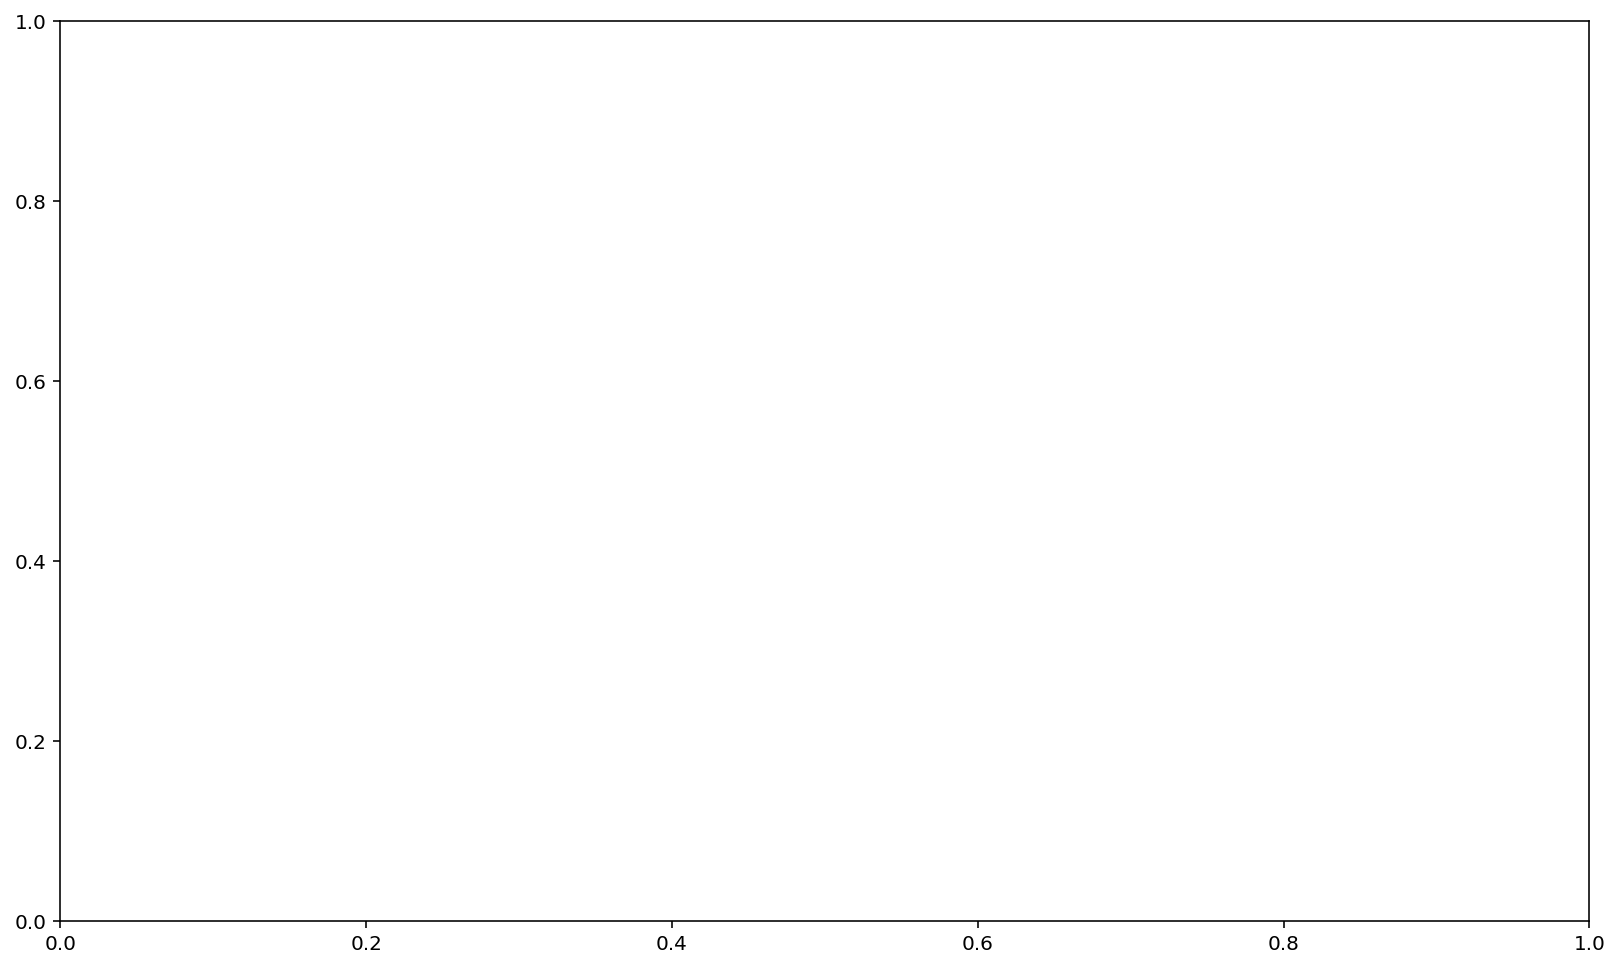

In [67]:
import seaborn as sns

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, ax = plt.subplots(1,1, figsize=(13.7,8.27))
sns.set_style("white")
sns.set_context("talk")
sns.lineplot(data=df, x="Label Percentage (%)", y="Accuracy", hue="Models", marker="o", ax=ax)
ax.set_xticks([l*100 for l in label_percentages[2:]])
ax.set_ylim([0.2,1])
sns.despine()
ax.axhline(0.9357, ls='--', c="gray")
ax.text(-1,0.95, "100% Data\n    SOTA", c="gray")

In [ ]:
import seaborn as sns
sns.relplot()

In [66]:
out

data                                models    lab  accuracy          
                                                               mean       std
0    enzymes  ssl_classifier_gcnp_unetgcn_finetune  0.01%  0.186667  0.028109
1    enzymes  ssl_classifier_gcnp_unetgcn_finetune  0.05%  0.360000  0.022498
2    enzymes  ssl_classifier_gcnp_unetgcn_finetune   0.1%  0.406667  0.032584
3    enzymes  ssl_classifier_gcnp_unetgcn_finetune   0.3%  0.465000  0.031866
4    enzymes  ssl_classifier_gcnp_unetgcn_finetune   0.5%  0.526667  0.031623
5    enzymes  ssl_classifier_gcnp_unetgcn_finetune     1%  0.668333  0.051190
6    enzymes                  supervised_gat_large  0.01%  0.258333  0.032632
7    enzymes                  supervised_gat_large  0.05%  0.311667  0.055583
8    enzymes                  supervised_gat_large   0.1%  0.363333  0.042889
9    enzymes                  supervised_gat_large   0.3%  0.496667  0.090880
10   enzymes                  supervised_gat_large   0.5%  0.505000  0.081669
11   enzymes                  supervised_gat_large     1%  0.615000  0.089045
12   enzymes                 supervised_gin0_large  0.01%  0.291667  0.059447
13   enzymes                 supervised_gin0_large  0.05%  0.318333  0.060067
14   enzymes                 supervised_gin0_large   0.1%  0.400000  0.047140
15   enzymes                 supervised_gin0_large   0.3%  0.546667  0.054320
16   enzymes                 supervised_gin0_large   0.5%  0.543333  0.063925
17   enzymes                 supervised_gin0_large     1%  0.648333  0.048718
18  proteins  ssl_classifier_gcnp_unetgcn_finetune  0.01%  0.621429  0.032384
19  proteins  ssl_classifier_gcnp_unetgcn_finetune  0.05%  0.756250  0.011942
20  proteins  ssl_classifier_gcnp_unetgcn_finetune   0.1%  0.750000  0.014580
21  proteins  ssl_classifier_gcnp_unetgcn_finetune   0.3%  0.759821  0.010689
22  proteins  ssl_classifier_gcnp_unetgcn_finetune   0.5%  0.758036  0.006588
23  proteins  ssl_classifier_gcnp_unetgcn_finetune     1%  0.756250  0.004313
24  proteins                  supervised_gat_large  0.01%  0.617857  0.037125
25  proteins                  supervised_gat_large  0.05%  0.680357  0.024105
26  proteins                  supervised_gat_large   0.1%  0.720536  0.036946
27  proteins                  supervised_gat_large   0.3%  0.749107  0.029896
28  proteins                  supervised_gat_large   0.5%  0.776786  0.055360
29  proteins                  supervised_gat_large     1%  0.799107  0.037232
30  proteins                 supervised_gin0_large  0.01%  0.600893  0.054400
31  proteins                 supervised_gin0_large  0.05%  0.658929  0.048504
32  proteins                 supervised_gin0_large   0.1%  0.698214  0.032819
33  proteins                 supervised_gin0_large   0.3%  0.718750  0.032940
34  proteins                 supervised_gin0_large   0.5%  0.754464  0.030132
35  proteins                 supervised_gin0_large     1%  0.766071  0.036886
36   synthie  ssl_classifier_gcnp_unetgcn_finetune  0.01%  0.535000  0.033747
37   synthie  ssl_classifier_gcnp_unetgcn_finetune  0.05%  0.595000  0.010541
38   synthie  ssl_classifier_gcnp_unetgcn_finetune   0.1%  0.555000  0.034960
39   synthie  ssl_classifier_gcnp_unetgcn_finetune   0.3%  0.640000  0.039441
40   synthie  ssl_classifier_gcnp_unetgcn_finetune   0.5%  0.587500  0.029463
41   synthie  ssl_classifier_gcnp_unetgcn_finetune     1%  0.642500  0.040910
42   synthie                  supervised_gat_large  0.01%  0.387500  0.061520
43   synthie                  supervised_gat_large  0.05%  0.387500  0.081862
44   synthie                  supervised_gat_large   0.1%  0.440000  0.100830
45   synthie                  supervised_gat_large   0.3%  0.517500  0.069771
46   synthie                  supervised_gat_large   0.5%  0.507500  0.084204
47   synthie                  supervised_gat_large     1%  0.517500  0.063519
48   synthie                 supervised_gin0_large  0.01%  0.405000  0.062138
49   synthie                 s